In [ ]:
import numpy as np
import nltk
nltk.download('stopwords')
!pip install chart_studio
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
#from keras.utils.np_utils import to_categorical
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.layers import Dropout
import re
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('english'))
from bs4 import BeautifulSoup
import plotly.graph_objs as go
#import plotly.plotly as py
import chart_studio.plotly as py
import cufflinks
from IPython.core.interactiveshell import InteractiveShell
import plotly.figure_factory as ff
InteractiveShell.ast_node_interactivity = 'all'
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 1.7 MB/s eta 0:00:00


In [ ]:
df = pd.read_csv("consumer_complaints.csv")


In [ ]:
df= df[['Product', 'Consumer Complaint']]

In [ ]:
df.head()

,Product,Consumer Complaint
0,Mortgage,NaN
1,Credit reporting,I have outdated information on my credit repor...
2,Consumer Loan,I purchased a new car on XXXX XXXX. The car de...
3,Credit card,NaN
4,Debt collection,NaN


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404169 entries, 0 to 404168
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Product             404169 non-null  object
 1   Consumer Complaint  91859 non-null   object
dtypes: object(2)
memory usage: 6.2+ MB


In [ ]:
df.Product.value_counts()

Mortgage                                                                        113111
Debt collection                                                                  76724
Credit reporting                                                                 68444
Credit card                                                                      43206
Bank account or service                                                          41130
Student loan                                                                     17006
Consumer Loan                                                                    15199
Credit reporting, credit repair services, or other personal consumer reports     13701
Credit card or prepaid card                                                       3236
Checking or savings account                                                       2953
Payday loan                                                                       2655
Money transfers                            

In [ ]:
df.loc[df['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df.loc[df['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df.loc[df['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df.loc[df['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df = df[df.Product != 'Other financial service']

In [ ]:
import plotly.graph_objects as go

# Assuming you have a DataFrame named 'df'
product_counts = df['Product'].value_counts().sort_values(ascending=False)

# Define fluorescent colors for each bar (you can use any hex color codes)
fluorescent_colors = ['#FF00FF', '#00FF00', '#FF0000', '#FFFF00', '#00FFFF']  # Example fluorescent colors

# Create a bar chart with fluorescent colors
fig = go.Figure(data=[go.Bar(x=product_counts.index, y=product_counts, marker=dict(color=fluorescent_colors))])

# Customize the chart layout
fig.update_layout(
    title='Number of Complaints in Each Product',
    xaxis_title='Product',
    yaxis_title='Number of Complaints'
)

# Show the chart in Colab with the "colab" renderer
fig.show(renderer="colab")


In [ ]:
def print_plot(index):
    example = df[df.index == index][['Consumer Complaint', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])

In [ ]:
print_plot(10)

nan
Product: Mortgage


In [ ]:
print_plot(1)

I have outdated information on my credit report that I have previously disputed that has yet to be removed this information is more then seven years old and does not meet credit reporting requirements
Product: Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    if isinstance(text, str):  # Check if the text is a string
        text = text.lower()  # Lowercase text
        text = re.sub(REPLACE_BY_SPACE_RE, ' ', text)  # Replace symbols with space
        text = re.sub(BAD_SYMBOLS_RE, '', text)  # Remove bad symbols
        text = ' '.join(word for word in text.split() if word not in STOPWORDS)  # Remove stopwords
    return text

# Assuming you have defined REPLACE_BY_SPACE_RE, BAD_SYMBOLS_RE, and STOPWORDS earlier

df['Consumer Complaint'] = df['Consumer Complaint'].apply(clean_text)

In [ ]:
df['Consumer Complaint'] = df['Consumer Complaint'].str.replace('\d+', '')


<ipython-input-13-b458134a71d7>:1: FutureWarning:

The default value of regex will change from True to False in a future version.



In [ ]:
# Choosing a smaller sample data to arrrive at the training faster
df = df.sample(n=361574)

In [ ]:
print_plot(19)

nan
Product: Credit reporting, credit repair services, or other personal consumer reports


In [ ]:
df['Consumer Complaint'] = df['Consumer Complaint'].apply(lambda x: str(x))


In [ ]:
df['Consumer Complaint'] = df['Consumer Complaint'].apply(clean_text)

In [ ]:
# The maximum number of words to be used. (most frequent)
# specify most frequent words to consider & limit the vocabulary to avoid overfitting & reduce computational complexity
MAX_NB_WORDS = 50000
# Max number of words in each complaint. If a text sequence exceeds this length, it will be truncated
# ..and if it's shorter, it will be padded to reach this length
# This helps to ensure that all text input have consistent shape, which is important when feeding data into neural networks

MAX_SEQUENCE_LENGTH = 250

# This variable specifies the dimensionality of word embeddings
# In NLP, word embeddings are dense vector representations of words that capture semantic relationships between words
# Common embedding dimensions include 50, 100, 200, or 300
EMBEDDING_DIM = 100

# fit the tokenizer on the text data. Process the text & build a vocabulary based on the most frequent words encountered
# in the 'Consumer complaint narrative' column of the DataFrame
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Consumer Complaint'].values)

# "word_index" stores the word-to-index mapping generated by the tokenizer. Each unique word in the text is assigned an index
# It's important for converting text data into numerical sequences
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 62605 unique tokens.


In [ ]:
# The tokenizer converts the text data into sequences of integers using the word-to-index mapping
# Each word in the text is replaced with its corresponding index, which is a crucial step in preparing data for modeling
X = tokenizer.texts_to_sequences(df['Consumer Complaint'].values)

# This line pads or truncates the sequences to ensure that they all have the same length, as defined by MAX_SEQUENCE_LENGTH
# Text sequences shorter than this length are padded with zeros, while longer sequences are truncated
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (361574, 250)


In [ ]:
Y = pd.get_dummies(df["Product"]).values

print("Shape of Data Tensor:", X.shape)

Shape of Data Tensor: (361574, 250)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(325416, 250) (325416, 13)
(36158, 250) (36158, 13)


In [ ]:
"""
Embedding Layer: This layer is responsible for learning & representing word embeddings. It takes as input integer-encoded
sequences (words represented as integers) & transforms them into dense vectors of fixed size (EMBEDDING_DIM).
This layer is crucial for understanding the contextual meaning of words in your text data

SpatialDropout1D Layer: Spatial dropout is a variation of traditional dropout that randomly sets a fraction of input
units to 0 at each update during training. It helps prevent overfitting by dropping entire 1D feature maps (channels)
instead of individual elements

LSTM Layer: Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) layer that is well-suited for
sequential data like text. It can capture long-range dependencies in the input sequences.
The layer has 100 LSTM units and uses dropout for regularization

Dense Layer with Softmax Activation: This is the output layer of your neural network. It has 13 units
(assuming you have 13 classes for classification) and uses the softmax activation function.
Softmax converts the model's raw output scores into probabilities for each class,
making it suitable for multi-class classification problems

Compilation: In this step, you configure the training process for your model. You specify the loss function
(categorical crossentropy, commonly used for classification), the optimizer (Adam), and the evaluation metric (accuracy)

Model Summary: The model.summary() function prints a summary of your model's architecture, including the number of
parameters in each layer
"""
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(13, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

"\nEmbedding Layer: This layer is responsible for learning and representing word embeddings. It takes as input\ninteger-encoded sequences (words represented as integers) and transforms them into dense vectors of fixed size (EMBEDDING_DIM).\nThis layer is crucial for understanding the contextual meaning of words in your text data\n\nSpatialDropout1D Layer: Spatial dropout is a variation of traditional dropout that randomly sets a fraction of\ninput units to 0 at each update during training. It helps prevent overfitting by dropping entire 1D feature maps (channels)\ninstead of individual elements\n\nLSTM Layer: Long Short-Term Memory (LSTM) is a type of recurrent neural network (RNN) layer that is well-suited for\nsequential data like text. It can capture long-range dependencies in the input sequences.\nThe layer has 100 LSTM units and uses dropout for regularization\n\nDense Layer with Softmax Activation: This is the output layer of your neural network. It has 13 units\n(assuming you ha

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          5000000   
                                                                 
 spatial_dropout1d (SpatialD  (None, 250, 100)         0         
 ropout1D)                                                       
                                                                 
 lstm (LSTM)                 (None, 100)               80400     
                                                                 
 dense (Dense)               (None, 13)                1313      
                                                                 
Total params: 5,081,713
Trainable params: 5,081,713
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 5
batch_size = 64

history = model.fit(X_train,
                    Y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_split=0.1,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                             patience=3,
                                             min_delta=0.0001)])

Epoch 1/5
4577/4577 [==============================] - 1060s 231ms/step - loss: 1.6946 - accuracy: 0.3826 - val_loss: 1.5967 - val_accuracy: 0.4140
Epoch 2/5
4577/4577 [==============================] - 1064s 232ms/step - loss: 1.5671 - accuracy: 0.4250 - val_loss: 1.5585 - val_accuracy: 0.4240
Epoch 3/5
4577/4577 [==============================] - 1033s 226ms/step - loss: 1.5383 - accuracy: 0.4325 - val_loss: 1.5470 - val_accuracy: 0.4269
Epoch 4/5
4577/4577 [==============================] - 1030s 225ms/step - loss: 1.5200 - accuracy: 0.4378 - val_loss: 1.5500 - val_accuracy: 0.4259
Epoch 5/5
4577/4577 [==============================] - 1034s 226ms/step - loss: 1.5050 - accuracy: 0.4424 - val_loss: 1.5542 - val_accuracy: 0.4260


In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

1130/1130 [==============================] - 47s 41ms/step - loss: 1.5422 - accuracy: 0.4301
Test set
  Loss: 1.542
  Accuracy: 0.430


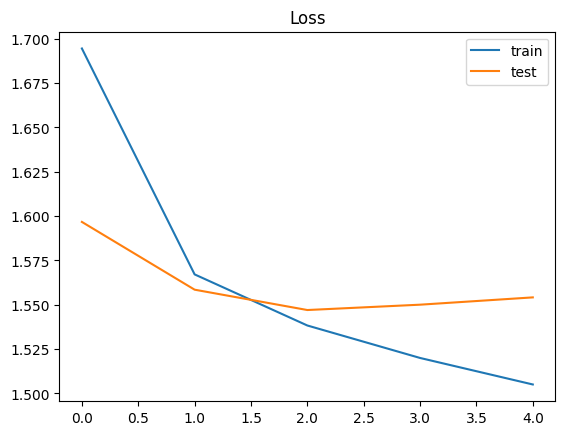

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

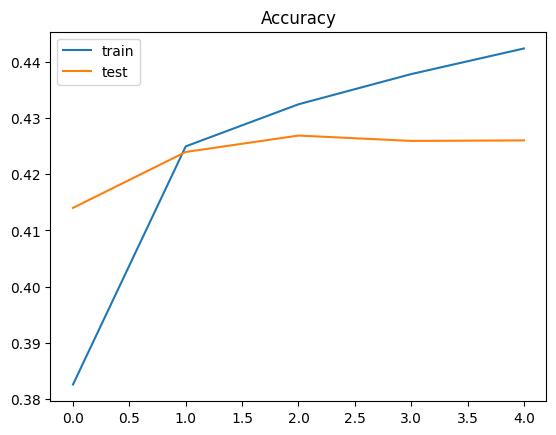

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [ ]:
new_complaint = ['I am a victim of identity theft and someone stole my identity and personal information to open up a Visa credit card account with Bank of America. The following Bank of America Visa credit card account do not belong to me : XXXX.']
seq = tokenizer.texts_to_sequences(new_complaint)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['Credit reporting, credit repair services, or other personal consumer reports', 'Debt collection', 'Mortgage', 'Credit card or prepaid card', 'Student loan', 'Bank account or service', 'Checking or savings account', 'Consumer Loan', 'Payday loan, title loan, or personal loan', 'Vehicle loan or lease', 'Money transfer, virtual currency, or money service', 'Money transfers', 'Prepaid card']
print(pred, labels[np.argmax(pred)])

1/1 [==============================] - 0s 313ms/step
[[4.7432659e-03 1.8564740e-04 2.0224417e-03 9.8463166e-01 4.8674792e-03
  3.0166714e-03 1.0490884e-05 9.2271448e-06 2.6696740e-04 5.1241706e-05
  7.8440600e-05 5.0839401e-05 6.5605615e-05]] Credit card or prepaid card
